In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df_HN=pd.read_csv('../data/bitcoin/HackerNews_bitcoin_price.csv')
print('Head\n------')
print(df_HN.head())
print('\n\n')
print('Tail\n------')
print(df_HN.tail())
print('\n\n')
print('description\n------')
print(df_HN.describe())

Head
------
             date  price
0   1/5/2009 0:00    0.0
1   1/7/2009 0:00    0.0
2   1/9/2009 0:00    0.0
3  1/11/2009 0:00    0.0
4  1/13/2009 0:00    0.0



Tail
------
                date         price
1669  2/25/2018 0:00   9696.593333
1670  2/27/2018 0:00  10763.883330
1671   3/1/2018 0:00  11009.381670
1672   3/3/2018 0:00  11326.948330
1673   3/5/2018 0:00  11595.540000



description
------
              price
count   1674.000000
mean     826.226482
std     2351.869070
min        0.000000
25%        1.285675
50%      122.835005
75%      568.750000
max    19289.785000


In [3]:
df_HN['date']=pd.to_datetime(df_HN['date'])
df_HN.index = df_HN['date']
df_HN.drop(columns=['date'],inplace=True)
df_HN.freq=pd.infer_freq(df_HN.index)

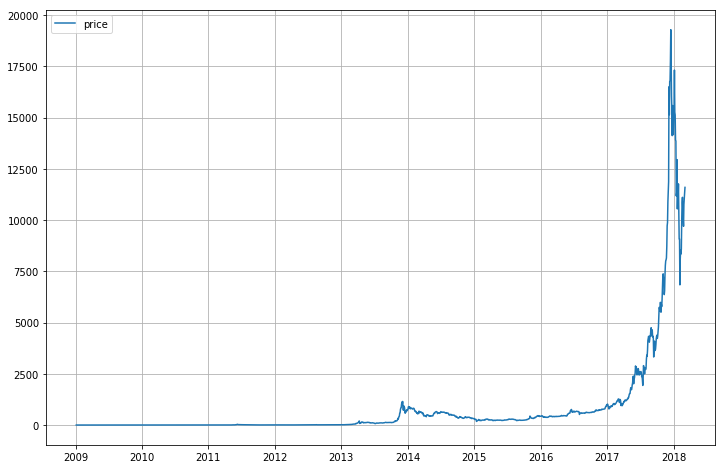

In [4]:
f2=plt.figure(figsize=(12,8))
plt.plot(df_HN.index,df_HN['price'],label='price')
plt.grid()
plt.legend()

## Create a simple RNN with normal cells

In [5]:
# setup the constants
n_time_steps = 30
n_inputs = 1 # Num of inputs per time_step. Just the avg price per day
n_neurons = 300 # Neurons per cell. This cell will be unrolled n_time_steps times
n_outputs = 1 # Predicted price per time step

In [6]:
# create placeholders for inputs and output
X = tf.placeholder(tf.float32,[None,n_time_steps,n_inputs])
y = tf.placeholder(tf.float32,[None,n_time_steps,n_outputs])

In [7]:
# create the cell definition
# We use output wrapper because the output/state of the cell will be of n_neurons size while we want 
# y to be of size 1. Hence, the wrapper will project the output in n_neurons-D to 1D using a linear map
# with trainable weights
cell = tf.contrib.rnn.OutputProjectionWrapper(
       tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,activation=tf.nn.relu),
       output_size=n_outputs)

In [8]:
# training constants
learning_rate=0.00005
n_iterations = 2000
batch_size = 200 

In [9]:
import random
random.seed(1)
np.random.seed(1)
def He_number_generator(batch_size, n_in, n_out):
    init_values=np.ndarray(shape=(batch_size,n_in))
    r = np.sqrt(2)*np.sqrt(6/(n_in + n_out))
    for batch in range(batch_size):
        init_values[batch] = np.random.uniform(low=-r,high=r,size=(1,n_in))
    return init_values

initial_state_values=tf.constant(He_number_generator(batch_size,n_neurons,n_neurons),dtype=tf.float32)
initial_state_values

<tf.Tensor 'Const:0' shape=(200, 300) dtype=float32>

In [10]:
outputs, final_states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32,initial_state=initial_state_values)

In [26]:
# function to fetch a mini-batch at every iteration

def fetch_batch(X, batch_size, instance_length, shifts_for_y=1):
    X_batch=np.ndarray(shape=(batch_size,instance_length,n_inputs))
    y_batch=np.ndarray(shape=(batch_size,instance_length,n_outputs))
    for i_instance in range(batch_size):
        start_date=random.choice(X.index[:-instance_length - shifts_for_y + 1]) 
        instance_index = pd.date_range(start=start_date,periods=instance_length+shifts_for_y,freq=X.freq)
        X_instance_index=instance_index[:-shifts_for_y]
        y_instance_index=instance_index[shifts_for_y:]
        X_batch[i_instance] = X.loc[X_instance_index].values
        y_batch[i_instance] = X.loc[y_instance_index].values
    return X_batch, y_batch

In [27]:
loss=tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()

In [28]:
# prepare the data 
# lets train using data between 2014-01-01 to 2017-07-30
# predict for a instance in 2017-08-01 to last
train_start_date = pd.to_datetime('2014-01-01')
train_end_date = pd.to_datetime('2017-07-30')
test_start_date = pd.to_datetime('2017-08-01')
train_df = df_HN.loc[train_start_date:train_end_date]
test_df = df_HN.loc[test_start_date:]
test_df.freq = pd.infer_freq(test_df.index)
train_df.freq = pd.infer_freq(train_df.index)

In [29]:

# start training session
sess = tf.InteractiveSession()
init.run()
for iteration in range(n_iterations):
    X_batch, y_batch = fetch_batch(train_df, batch_size, n_time_steps)
    sess.run(training_op, feed_dict={X:X_batch, y: y_batch})
    if iteration % 100 == 0:
        mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
        print(iteration, "\tMSE : ",mse)

0 	MSE :  555684.4
100 	MSE :  31678.445
200 	MSE :  20706.385
300 	MSE :  17518.07
400 	MSE :  14795.297
500 	MSE :  11395.514
600 	MSE :  9498.486
700 	MSE :  10681.371
800 	MSE :  9595.838
900 	MSE :  9134.552
1000 	MSE :  8304.749
1100 	MSE :  8257.536
1200 	MSE :  8703.837
1300 	MSE :  7841.38
1400 	MSE :  7230.739
1500 	MSE :  6758.3813
1600 	MSE :  6643.3687
1700 	MSE :  6634.219
1800 	MSE :  4790.7197
1900 	MSE :  5856.3506


In [33]:
test_X, test_y = fetch_batch(test_df,batch_size,n_time_steps)

In [34]:
y_pred = sess.run(outputs,feed_dict={X:test_X})

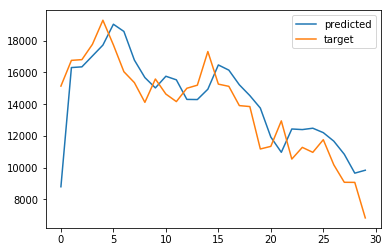

In [44]:
i=20
plt.figure()
plt.plot(y_pred[i],label='predicted')
plt.plot(test_y[i],label='target')
plt.legend()

In [42]:
logdir='logs/basic_RNN_for_bitcoin'

In [43]:
writer = tf.summary.FileWriter(logdir,sess.graph)

In [ ]:
cell2=tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,activation=tf.nn.relu)

In [ ]:
cell.trainable_weights[0].initializer

In [ ]:
tf.contrib.framework.nest.map_structure()

In [ ]:
import pdb

In [ ]:
cell2

In [24]:
a=np.array([1,2,3])

In [25]:
a[:-1]

array([1, 2])